In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import tensorflow as tf 

import warnings
import logging
from IPython.display import clear_output
warnings.filterwarnings('ignore')
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.disable(logging.WARNING)

from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [10]:
data_path = './bdd100k_seg/bdd100k/seg/'
exts = ('jpg', 'JPG', 'png', 'PNG',)
image_path = os.path.join(data_path, 'images', 'train')
label_path = os.path.join(data_path, 'labels', 'train')

In [11]:
images = sorted(
    [
        os.path.join(image_path, fname)
        for fname in os.listdir(image_path)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)

masks = sorted(
    [
        os.path.join(label_path, fname)
        for fname in os.listdir(label_path)
        if fname.endswith(exts) and not fname.startswith(".")
    ]
)

In [12]:
print("Number of samples:", len(images), len(masks))
for input_path, target_path in zip(images[:10], masks[:10]):
    print(input_path[-28:], "|", target_path[-37:])

Number of samples: 7000 7000
\train\0004a4c0-d4dff0ad.jpg | \train\0004a4c0-d4dff0ad_train_id.png
\train\00054602-3bf57337.jpg | \train\00054602-3bf57337_train_id.png
\train\00067cfb-e535423e.jpg | \train\00067cfb-e535423e_train_id.png
\train\00091078-59817bb0.jpg | \train\00091078-59817bb0_train_id.png
\train\0010bf16-a457685b.jpg | \train\0010bf16-a457685b_train_id.png
\train\001b428f-059bac33.jpg | \train\001b428f-059bac33_train_id.png
\train\001c2a14-c7138401.jpg | \train\001c2a14-c7138401_train_id.png
\train\0024b742-acbefa1a.jpg | \train\0024b742-acbefa1a_train_id.png
\train\0027eed2-09c90000.jpg | \train\0027eed2-09c90000_train_id.png
\train\0027eed2-09c90001.jpg | \train\0027eed2-09c90001_train_id.png


In [13]:
def display(display_list, extra_title=''):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask']

    if len(display_list) > len(title):
        title.append(extra_title)

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy().astype(np.uint8), cmap='viridis')
        plt.axis('off')
    plt.show()

In [14]:
id2label = {
    0:  'road',
    1:  'sidewalk',
    2:  'building',
    3:  'wall',
    4:  'fence',
    5:  'pole',
    6:  'traffic light',
    7:  'traffic sign',
    8:  'vegetation',
    9:  'terrain',
    10: 'sky',
    11: 'person',
    12: 'rider',
    13: 'car',
    14: 'truck',
    15: 'bus',
    16: 'train',
    17: 'motorcycle',
    18: 'bicycle',
}
label2id = { label: id for id, label in id2label.items() }
CLASSES = len(id2label)
CLASSES

19

In [15]:
train_img, test_img, train_msk, test_msk = train_test_split(
    images, masks, test_size=0.20, random_state=42
)

In [21]:
IMAGE_SIZE = 224
BATCH_SIZE = 6

def read_files(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image = tf.image.resize(
            images=image, 
            size=[IMAGE_SIZE, IMAGE_SIZE], 
            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
        )
        image = tf.where(image == 255, np.dtype('uint8').type(0), image)
        image = tf.cast(image, tf.float32)
    else:
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.cast(image, tf.float32)
    return image


Dataloader

In [22]:
def load_data(image_list, mask_list):
    image = read_files(image_list)
    mask = read_files(mask_list, mask=True)
    return image, mask

def data_generator_kcv(image_list, mask_list, split='train'):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.shuffle(10 * BATCH_SIZE) if split == 'train' else dataset 
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=False)
    return dataset.prefetch(tf.data.AUTOTUNE)

In [23]:
train_ds_kcv = data_generator_kcv(train_img, train_msk)
val_ds_kcv = data_generator_kcv(test_img, test_msk, split='validation')

(6, 224, 224, 3) (6, 224, 224, 1)


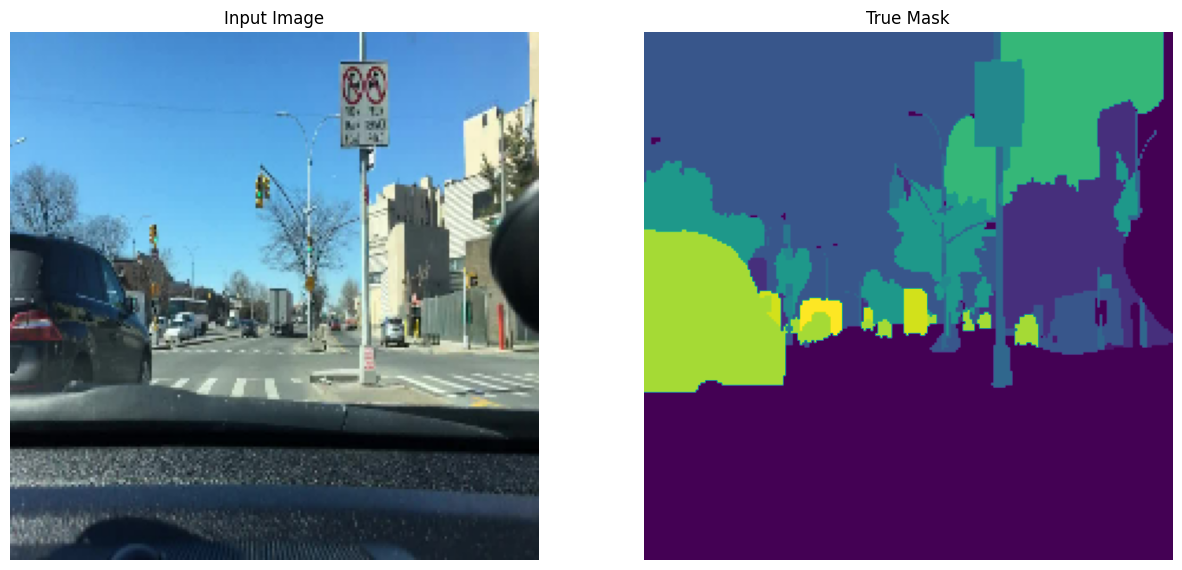

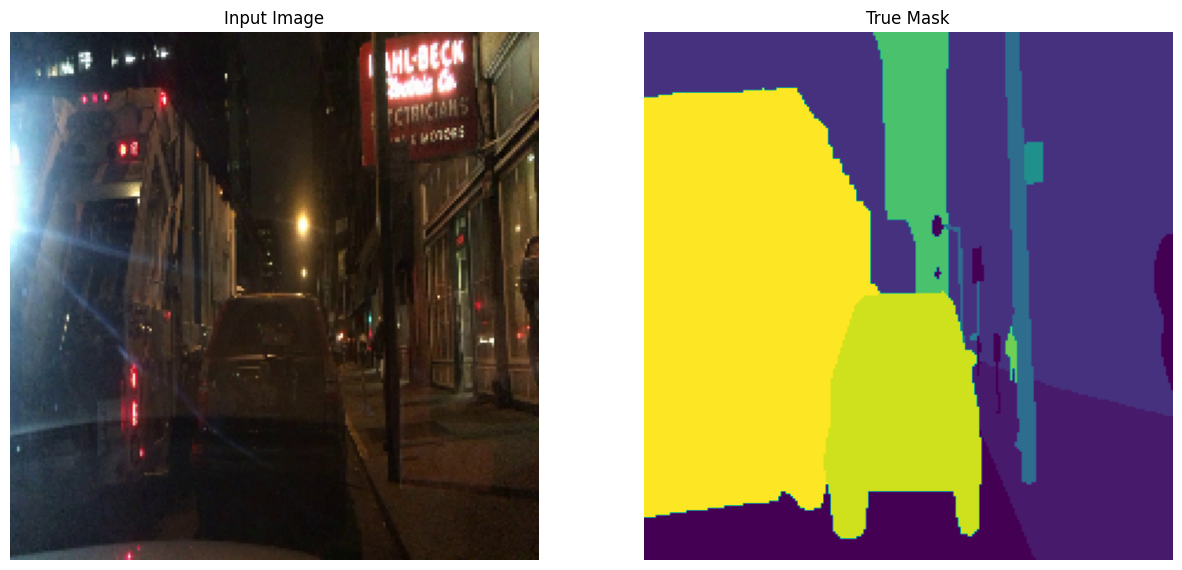

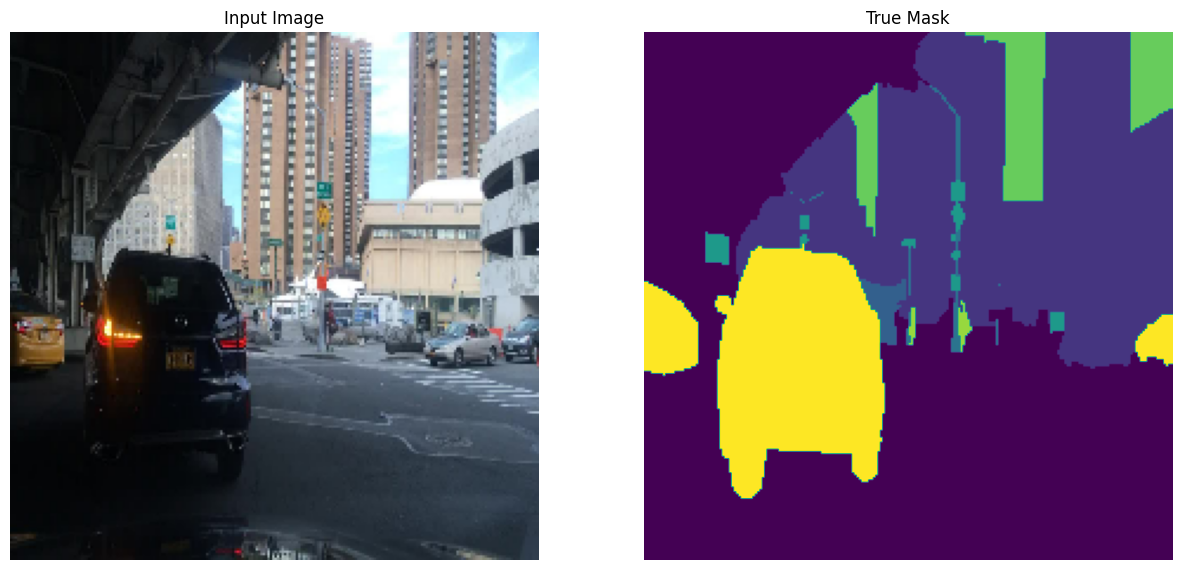

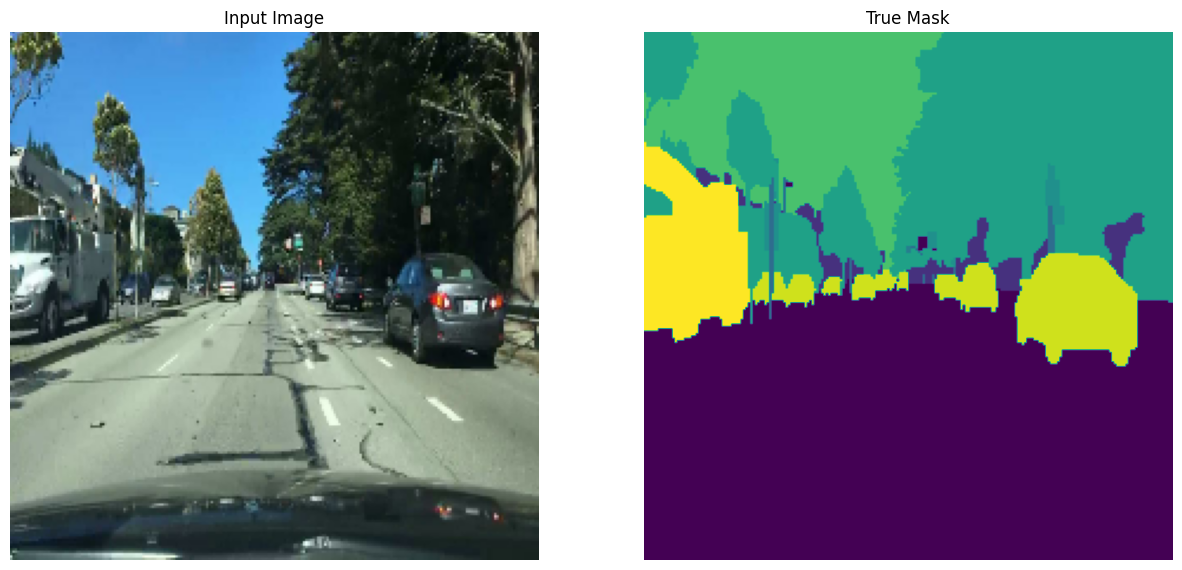

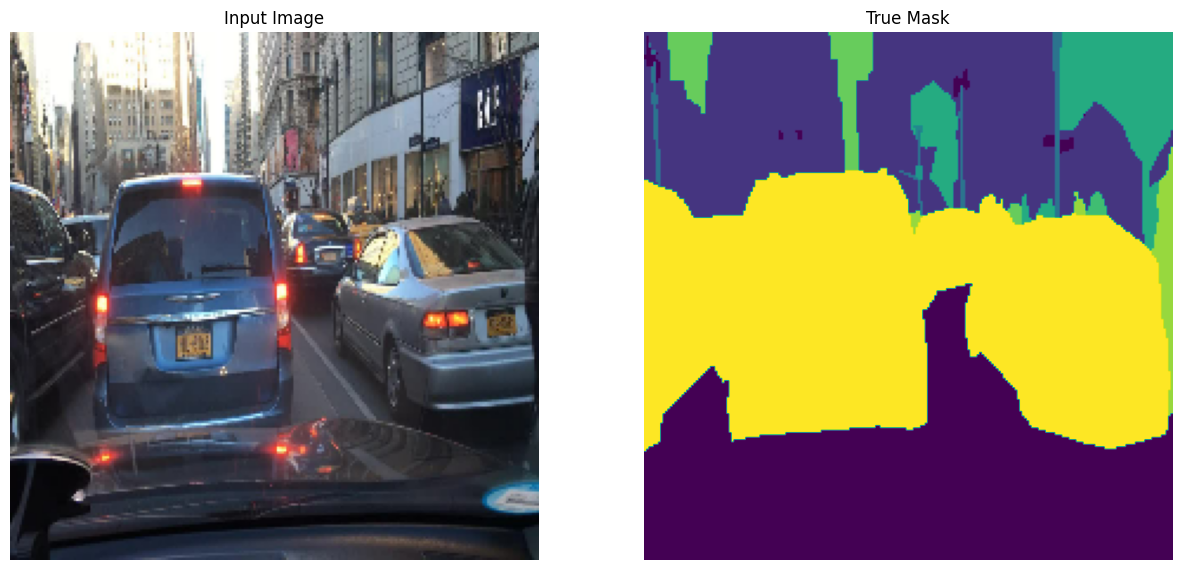

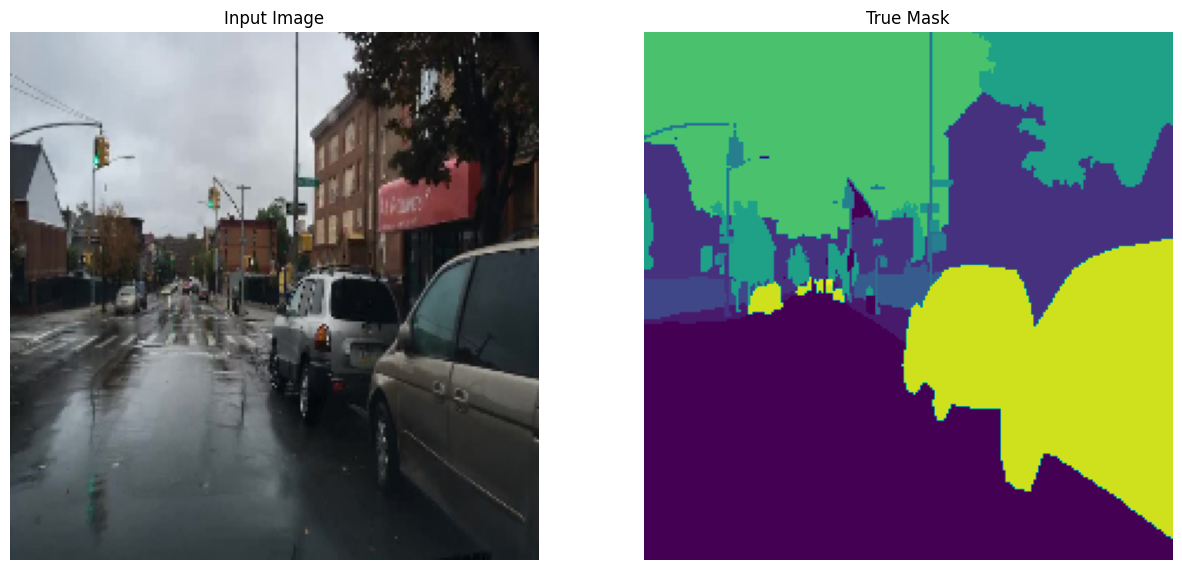

In [24]:
X, Y = next(iter(val_ds_kcv))
print(X.shape, Y.shape)

for x, y in zip(X, Y):
    display([x, y])

Model 1st Draft

In [31]:
import tensorflow as tf
from keras import layers, models
from keras.callbacks import EarlyStopping


def create_simple_unet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    
    #contracting path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    
    #expansive path
    u1 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = layers.concatenate([u1, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u1)
    
    u2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = layers.concatenate([u2, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    
    u3 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = layers.concatenate([u3, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    
    #output layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c7)
    
    #create the model
    model = models.Model(inputs=inputs, outputs=outputs)
    
    return model

#define input shape and number of classes
input_shape = (224, 224, 3)  
num_classes = 19  

#create the simpler U-Net model
model = create_simple_unet(input_shape, num_classes)

#compile the model
optim = tf.keras.optimizers.Adam(0.001)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = ["accuracy"]
model.compile(optimizer=optim, loss=loss_fn, metrics=metrics)

#define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=3,         
    restore_best_weights=True)


model.fit(train_ds_kcv, validation_data=val_ds_kcv, epochs=5, batch_size=64)


Epoch 1/5
934/934 [==============================] - 4319s 5s/step - loss: 1.3879 - accuracy: 0.6421 - val_loss: 1.0086 - val_accuracy: 0.7034
Epoch 2/5
934/934 [==============================] - 4192s 4s/step - loss: 0.9309 - accuracy: 0.7348 - val_loss: 0.8730 - val_accuracy: 0.7496
Epoch 3/5
934/934 [==============================] - 4172s 4s/step - loss: 0.8751 - accuracy: 0.7520 - val_loss: 0.8335 - val_accuracy: 0.7676
Epoch 4/5
934/934 [==============================] - 4185s 4s/step - loss: 0.8152 - accuracy: 0.7696 - val_loss: 0.8438 - val_accuracy: 0.7589
Epoch 5/5
934/934 [==============================] - 4177s 4s/step - loss: 0.7895 - accuracy: 0.7771 - val_loss: 0.7632 - val_accuracy: 0.7879


Training and Validation graphs

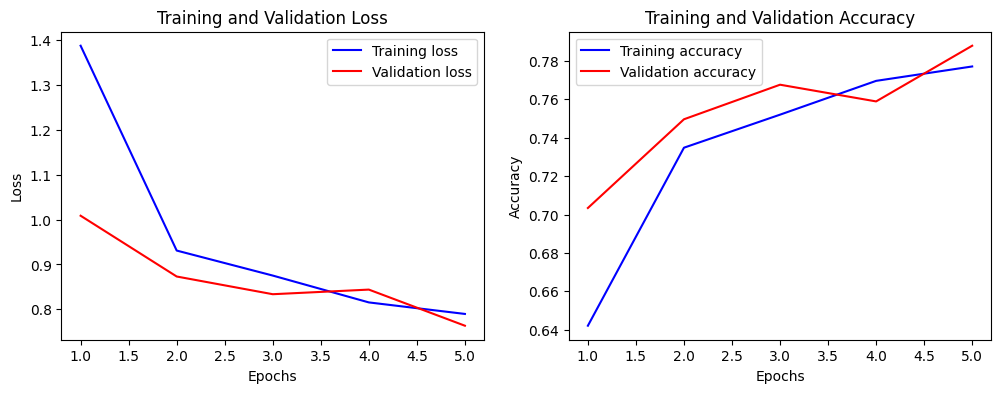

In [36]:
import matplotlib.pyplot as plt

#manually create lists to store loss and accuracy values from the printed logs
loss_values = [1.3879, 0.9309, 0.8751, 0.8152, 0.7895]  
val_loss_values = [1.0086, 0.8730, 0.8335, 0.8438, 0.7632]  
accuracy_values = [0.6421, 0.7348, 0.7520, 0.7696, 0.7771]  
val_accuracy_values = [0.7034, 0.7496, 0.7676, 0.7589, 0.7879]  

#plot the training and validation loss curves
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy_values, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Sample Predictions

1/1 [==============================] - 1s 983ms/step
(6, 224, 224, 3) (6, 224, 224, 1) (6, 224, 224)


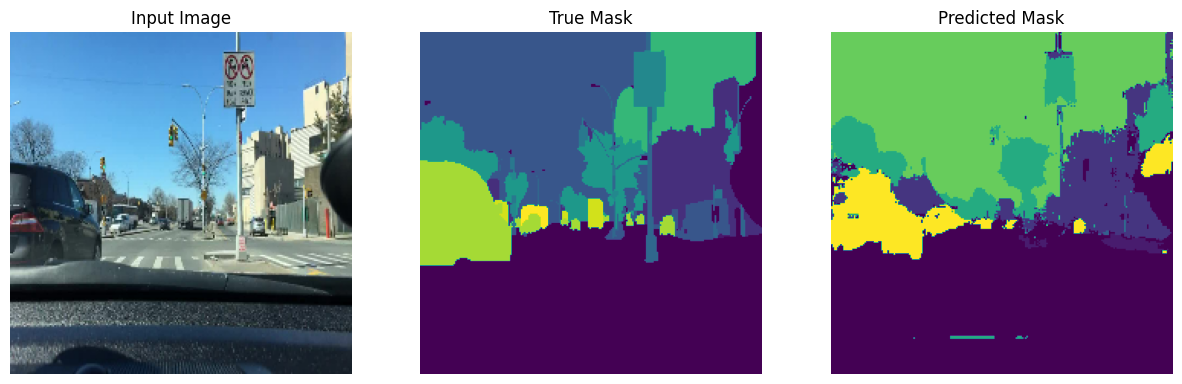

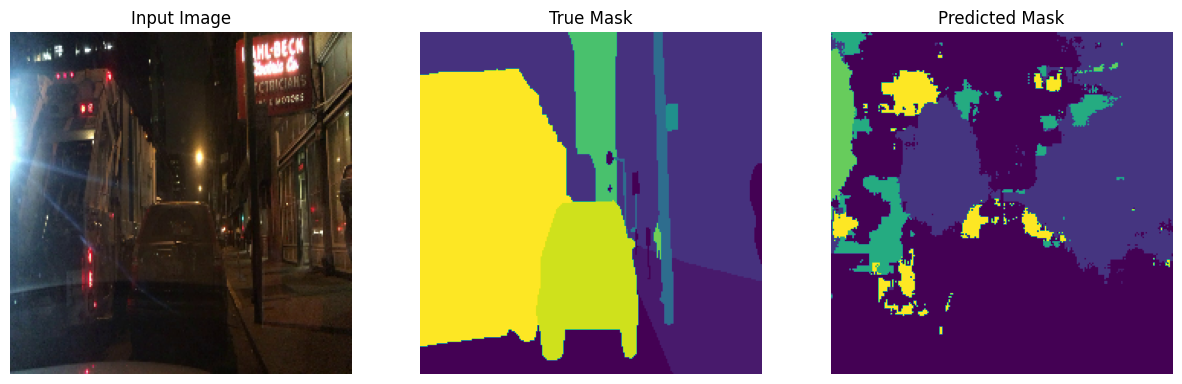

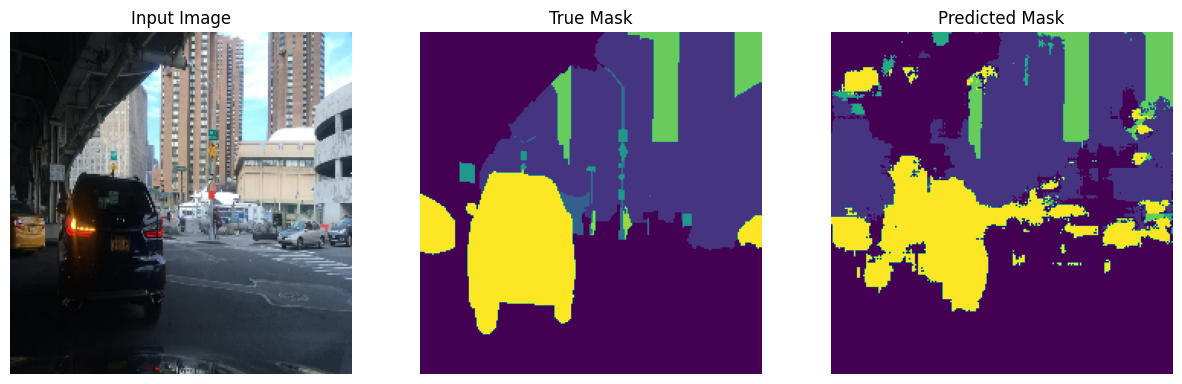

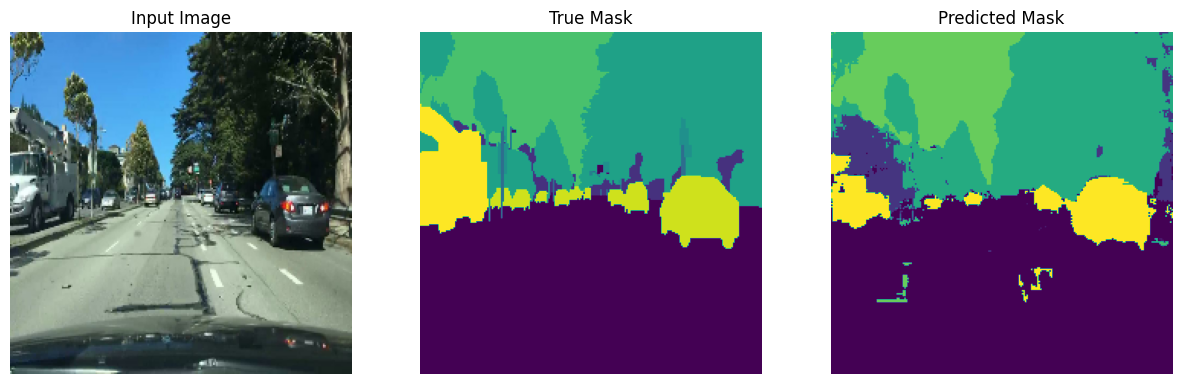

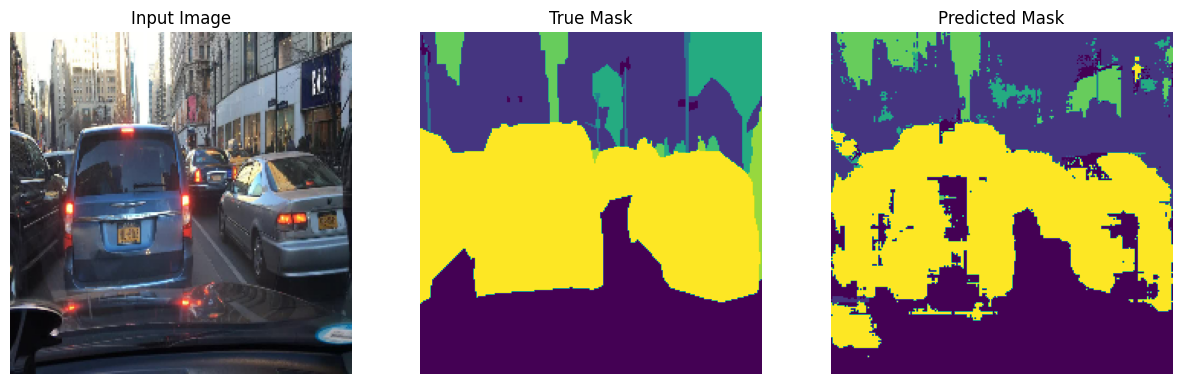

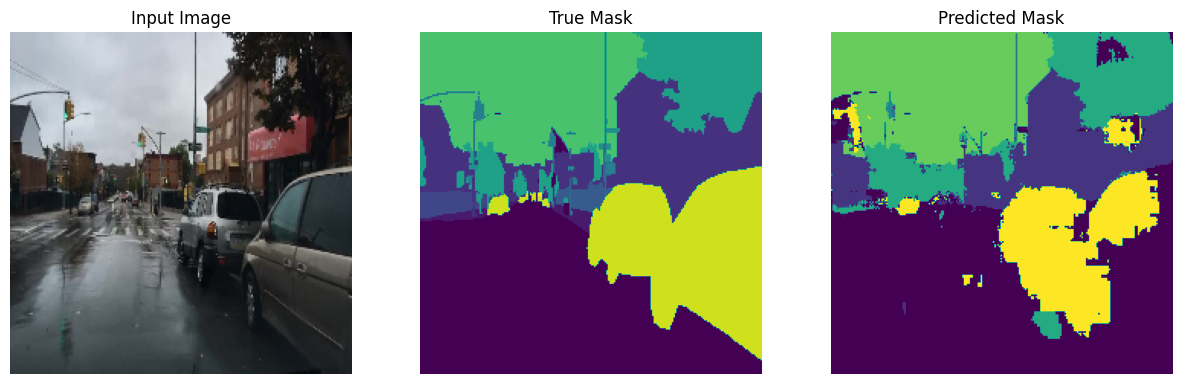

In [34]:
Y_PRED = model.predict(X)
Y_PRED = tf.math.argmax(Y_PRED, axis=-1)
print(X.shape, Y.shape, Y_PRED.shape)

for x, y, y_pred in zip(X, Y, Y_PRED):
    display([x, y, y_pred], extra_title='Predicted Mask')


Evaluations

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

#Y (ground truth) and Y_PRED (predicted) masks

#flatten the masks for calculations
Y_flat = tf.reshape(Y, [-1])  #reshape Y using tf.reshape
Y_PRED_flat = tf.reshape(Y_PRED, [-1])  #reshape Y_PRED using tf.reshape


accuracy = accuracy_score(Y_flat, Y_PRED_flat)
precision = precision_score(Y_flat, Y_PRED_flat, average='weighted')
recall = recall_score(Y_flat, Y_PRED_flat, average='weighted')
f1 = f1_score(Y_flat, Y_PRED_flat, average='weighted')

print(f"Overall Accuracy: {accuracy:.2f}")
print(f"Overall Precision: {precision:.2f}")
print(f"Overall Recall: {recall:.2f}")
print(f"Overall F1-score: {f1:.2f}")


Overall Accuracy: 0.69
Overall Precision: 0.62
Overall Recall: 0.69
Overall F1-score: 0.63


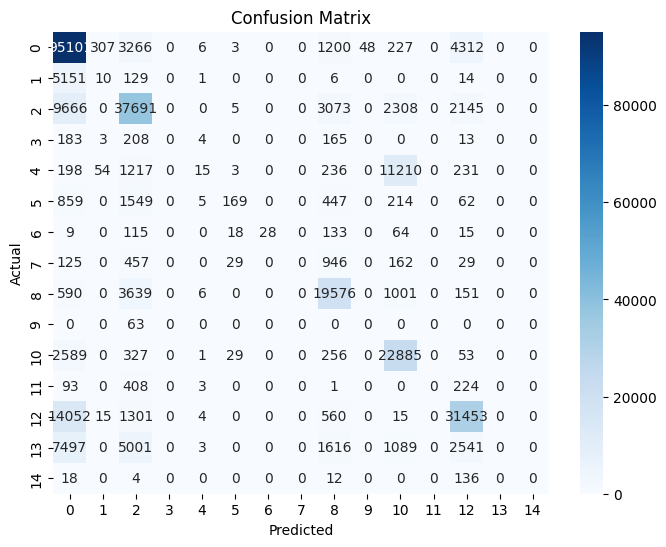

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
confusion = confusion_matrix(Y_flat, Y_PRED_flat)

# Create a heatmap for the confusion matrix without class labels
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues")

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

